# Project 1 
#### by Fabio, Ivan and Olivier

## Data Import

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
from implementations import *

# Loading the training data
y, tX, ids = load_csv_data('data/train.csv')

y_logistic =  [1. 0. 0. ... 1. 0. 0.]
y =  [ 1. -1. -1. ...  1. -1. -1.]


## Data Preprocessing

### Undefined values visualization

In [2]:
# LaTeX Typesetting
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{eulervm}',
    'font.family': 'serif',
    'font.serif': 'Palatino',
    'font.size': 11,
})

cm = 1/2.54  # Convert centimeters to inches
color_theme = '#2171b5'  # Color definition

Percentage of inputs with at least one undefined feature:  72.7544


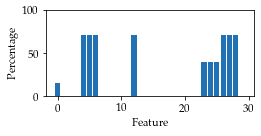

In [4]:
#Counting the number of undefined values
counter = np.sum((tX == -999), axis = 0)

#Percentage of undefined values
plt.figure(figsize=(9.5*cm, 4*cm))
N = tX.shape[0]
rel_counter = counter / N * 100
plt.bar(np.arange(len(rel_counter)), rel_counter, color=color_theme) 
plt.xlabel('Feature')
plt.ylabel('Percentage')
plt.ylim([0, 100])
plt.savefig('report/figures/undefined_values.pdf', bbox_inches='tight')


#Counting the percentage of inputs with at least one undefined feature 
counter = np.sum((tX == -999), axis = 1)
tot = np.count_nonzero(counter)
print("Percentage of inputs with at least one undefined feature: ", tot / N * 100)

Notes:
* Same number of undefined features for some features. This are structurally missing features.
* Very high percentage for some particular features.

### Replacing undefined entries

In [8]:
#Replacing undefined entrance:
tX_nan = np.where(tX != -999, tX, np.nan)

#1. With zero entries
tX_zeros = np.where(~np.isnan(tX_nan), tX_nan, 0)

#2. With mean
mu = np.nanmean(tX_nan, axis = 0)
tX_mean = np.where(~np.isnan(tX_nan), tX_nan, mu)

#3. With median
med = np.nanmedian(tX_nan, axis = 0)
tX_median = np.where(~np.isnan(tX_nan), tX_nan, med)

#4. Adding a binary variable
counter_nan = np.sum((tX == -999), axis = 0) / N
undef_ind = np.nonzero(counter_nan)[0]
tX_binary = np.hstack((tX, (2*np.isnan(tX_nan[:, undef_ind]) - 1)))

#5. Removing features with a percentage of undefined inputs above the threshold
threshold = 0.7
keep = np.argwhere(counter_nan < threshold).flatten()
tX_del = tX[:, keep]

# Creating a dictionary
tX_sets = {'normal': tX, 'zeros': tX_zeros, 'mean': tX_mean, 'median': tX_median, 'binary': tX_binary, 'deleted': tX_del}

## Visualizations

In [14]:
import pandas as pd
import collections

In [15]:
print(y.shape, tX.shape, ids.shape)
data = pd.read_csv('data/train.csv')
data.head(5)

(250000,) (250000, 30) (250000,)


,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [16]:
data.describe()

,Id,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,-0.010119,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,1.812223,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,-1.575000,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,-0.024000,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,1.561000,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,3.142000,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000


Visualize feature correlation

Ratio: 0.521


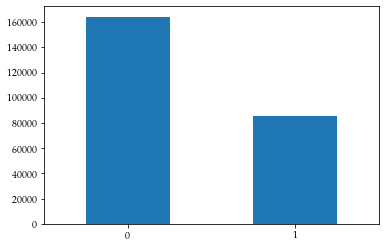

In [17]:
count = collections.Counter(y)
balance = [count[-1], count[1]]
vis = pd.Series(balance, index=range(len(balance)))
vis.plot(kind="bar", rot=0, color=color_theme)
plt.plot()
print("Ratio:", round(count[1]/count[-1],3))

## Parameter tuning

### Scoring functions

In [18]:
def f1_score(y_valid, tX_valid, weights):
    """
    Return the F1-score achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    f1 : float
        F1-score for this configuration (the closer to 1 the better)

    References
    ----------
    [1] Wikipedia entry for 'Precision and recall'
        https://en.wikipedia.org/wiki/Precision_and_recall
    [2] Wikipedia entry for 'F-score'
        https://en.wikipedia.org/wiki/F-score

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions

    # Calculating number of true positives, false positives, and false negatives
    num_tp = np.sum((y_valid == 1) & (y_pred == 1))
    num_fp = np.sum((y_valid == -1) & (y_pred == 1))
    num_fn = np.sum((y_valid == 1) & (y_pred == -1))
    precision = num_tp / (num_tp + num_fp)
    recall = num_tp / (num_tp + num_fn)
    f1 = np.round(2 * precision * recall / (precision + recall), 4)
    return f1

In [19]:
def accuracy(y_valid, tX_valid, weights):
    """
    Return the accuracy achieved with the predictions of a validation set

    Parameters
    ----------
    y_valid : np.ndarray
        Vector with the validation labels.
    tX_valid : np.ndarray
        Array with the validation samples as rows and the features as columns.
    weights : np.ndarray
        Vector containing the weights.

    Returns
    -------
    acc : float
        Accuracy for this configuration (the closer to 1 the better)

    References
    ----------
    [3] Wikipedia entry for 'Accuracy and precision'
        https://en.wikipedia.org/wiki/Accuracy_and_precision

    """

    y_pred = predict_labels(weights, tX_valid) # Obtaining the predictions
    num_tp_tn = np.sum(y_valid == y_pred) # Calculating number of true positives and negatives
    acc = np.round(num_tp_tn / len(y_valid), 4)
    return acc

### Cross validation

In [24]:
def cross_validate(regressor, y, tX, max_degree, offset, param, k_fold, score='accuracy'):
    """
    'k_fold' cross validate a regressor with parameters 'param', data '(y, TX)' 
    and score the predictions with 'score'

    Parameters
    ----------
    regressor : str
        String that defines which regressor to use
    y : np.ndarray
        Vector with the labels.
    tX : np.ndarray
        Array with the samples as rows and the features as columns.
    max_degree : int
        Highest degree element in polynomial basis.
    offset : bool
        Include offset or not in polynomial basis.
    param : np.ndarray
        Parameters on weight, gamma and max_iterations
    k_fold : int
        Integer that defines how many folds to make
    score : float
        Float of a given performance score (e.g. f1)

    Returns
    -------
    mean : float
        Mean of the scores achieved in k-fold cross validation
    std : float
        Standard deviation of scores achieved in k-fold cross validation

    """

    if offset:
        start = 0
    else:
        start = 1

    degrees = range(start, max_degree + 1)
    tX_poly = polynomial_basis(tX, degrees, std=True)

    fold_size = int(len(y) / k_fold) 
    rand_ind = np.random.permutation(np.arange(len(y)))

    scores = []
    for k in range(k_fold):
        valid_ind = rand_ind[k*fold_size:(k+1)*fold_size] # Splitting data set into validation and training set (for current fold)
        tX_train, y_train = tX_poly[valid_ind], y[valid_ind]
        tX_valid, y_valid = np.delete(tX_poly, valid_ind, axis=0), np.delete(y, valid_ind, axis=0)
        weights, _ = eval(regressor)(y_train, tX_train, **param) # Fitting/scoring regressor with the training/validation set
        score_valid = eval(score)(y_valid, tX_valid, weights)
        scores.append(score_valid)
    return np.mean(scores), np.std(scores, ddof=1)

In [25]:
def get_best_degree_params(regressor, y, tX, max_degree, offset, params, k_fold, score='accuracy', verbose=True):
    '''
    TODO: Description 
    '''
    # For each degree we compute the best lambda and the associated error
    best_degree = float('inf')
    if (score == 'accuracy' or score == 'f1_score'):
        best_loss = float('-inf')
    else:
        best_loss = float('inf')
    best_param = {}
    
    for degree in degrees:
        if verbose:
            print("Degree: ", degree)
        for param in params:
            loss_te, _ = cross_validate(regressor, y, tX, max_degree, offset, param, k_fold, score)
            
            if verbose:
                print("loss: ", loss_te)
            
            if (score == 'accuracy' or score == 'f1_score'):
                if loss_te > best_loss:
                    best_loss = loss_te
                    best_degree = degree
                    best_param = param  
            else: 
                if loss_te < best_loss:
                    best_loss = loss_te
                    best_degree = degree
                    best_param = param

        # Least squares has no parameters, we just need to find the optimal degree
        if (params == []):
            loss_te, _ = cross_validate(regressor, y, tX, max_degree, offset, {}, k_fold, score)
            if verbose:
                print("loss: ", loss_te)
            if (score == 'accuracy' or score == 'f1_score'):
                if loss_te > best_loss:
                    best_loss = loss_te
                    best_degree = degree 
            else: 
                if loss_te < best_loss:
                    best_loss = loss_te
                    best_degree = degree

    
    print("Best parameters set for '", regressor, "' using '", score, "' was:")
    print("degree = ", best_degree)
    print("param = ", best_param)
    print("Mean ", score, " score: ", best_loss)

    return best_degree, best_param

### Least squares gradient descent

<ipython-input-30-df98482cbf85>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.matshow(mean.astype(np.float))


<Figure size 269.291x198.425 with 0 Axes>

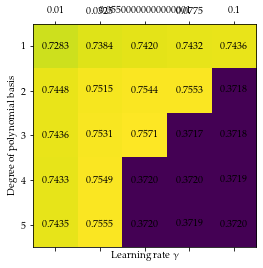

In [30]:
plt.figure(figsize=(9.5*cm, 7*cm))

degrees = np.linspace(1, 5, 5, dtype=int)
gammas = np.linspace(1e-2, 1e-1, 5)

mean, std = np.frompyfunc(
    lambda degree, gamma: cross_validate('least_squares_GD',
                                            y, tX, degree, True,
                                            {'gamma': gamma, 'max_iters': 200},
                                            4, 'accuracy'),
    2, 2).outer(degrees, gammas)

plt.matshow(mean.astype(np.float))
plt.xticks(range(len(gammas)), gammas)
plt.yticks(range(len(degrees)), degrees)
plt.xlabel(r'Learning rate $\gamma$')
plt.ylabel(r'Degree of polynomial basis')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

plt.savefig('report/figures/grad_desc_gridsearch.pdf', bbox_inches='tight')

### Least squares stochastic gradient descent

c:\Users\Fabio\Documents\ML_project1\implementations.py:289: RuntimeWarning: overflow encountered in multiply
  grad_rand = - e_rand * tX_rand # Random gradient for MSE loss
c:\Users\Fabio\Documents\ML_project1\implementations.py:290: RuntimeWarning: invalid value encountered in subtract
  w = w - gamma * grad_rand # Updating with scaled negative gradient
c:\Users\Fabio\Documents\ML_project1\implementations.py:178: RuntimeWarning: overflow encountered in square
  return np.mean((y - np.dot(tX, w))**2) / 2


<Figure size 269.291x198.425 with 0 Axes>

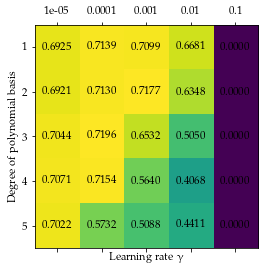

In [32]:
plt.figure(figsize=(9.5*cm, 7*cm))

degrees = np.linspace(1, 5, 5, dtype=int)
gammas = np.logspace(-5, -1, 5)

mean, std = np.frompyfunc(
    lambda degree, gamma: cross_validate('least_squares_SGD',
                                            y, tX, degree, False,
                                            {'gamma': gamma},
                                            4, 'accuracy'),
    2, 2).outer(degrees, gammas)

plt.matshow(mean.astype(np.float))
plt.xticks(range(len(gammas)), gammas)
plt.yticks(range(len(degrees)), degrees)
plt.xlabel(r'Learning rate $\gamma$')
plt.ylabel(r'Degree of polynomial basis')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

plt.savefig('report/figures/stoch_grad_desc_gridsearch.pdf', bbox_inches='tight')

### Ridge regression

<Figure size 269.291x198.425 with 0 Axes>

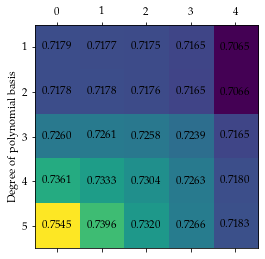

In [38]:
plt.figure(figsize=(9.5*cm, 7*cm))

degrees = np.linspace(1, 5, 5, dtype=int)
lambdas = np.logspace(-5, -1, 5)

mean, std = np.frompyfunc(
    lambda degree, lambda_: cross_validate('ridge_regression',
                                    y, tX, degree, False,
                                    {'lambda_' : lambda_},
                                    4, 'accuracy'),
    2, 2).outer(degrees, lambdas)

plt.matshow(mean.astype(np.float))
plt.xticks(range(len(lambdas)), lambdas)
plt.yticks(range(len(degrees)), degrees)
plt.ylabel(r'Degree of polynomial basis')
plt.xlabel(r'Regulization $\lambda$')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

plt.savefig('report/figures/ridge_regression_gridsearch.pdf', bbox_inches='tight')

### Logistic regression

<ipython-input-37-b56140db6926>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.matshow(mean.astype(np.float))


<Figure size 269.291x198.425 with 0 Axes>

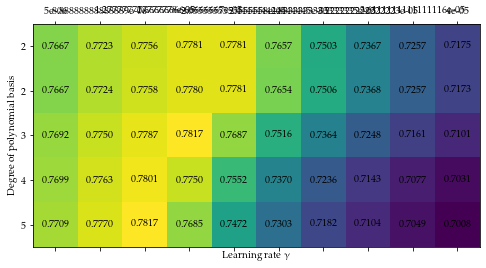

In [37]:
plt.figure(figsize=(9.5*cm, 7*cm))

degrees = np.linspace(2, 5, 5, dtype=int)
gammas = np.linspace(5e-6, 4e-5, 10)

mean, std = np.frompyfunc(
    lambda degree, gamma: cross_validate('logistic_regression',
                                            y, tX_median, degree, True,
                                            {'gamma' : gamma, 'max_iters': 100},
                                            4, 'accuracy'),
    2, 2).outer(degrees, gammas)

plt.matshow(mean.astype(np.float))
plt.xticks(range(len(gammas)), gammas)
plt.yticks(range(len(degrees)), degrees)
plt.xlabel(r'Learning rate $\gamma$')
plt.ylabel(r'Degree of polynomial basis')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

plt.savefig('report/figures/log_reg_gridsearch.pdf', bbox_inches='tight')

### Regularized logistic regression

<Figure size 269.291x198.425 with 0 Axes>

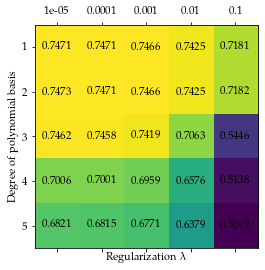

In [41]:
plt.figure(figsize=(9.5*cm, 7*cm))

degrees = np.linspace(1, 5, 5, dtype=int)
lambdas = np.logspace(-5, -1, 5)

mean, std = np.frompyfunc(
    lambda degree, lambda_: cross_validate('reg_logistic_regression',
                                            y, tX, degree, True,
                                            {'lambda_' : lambda_, 'gamma': 1e-5},
                                            4, 'accuracy'),
    2, 2).outer(degrees, lambdas)

plt.matshow(mean.astype(np.float))
plt.xticks(range(len(lambdas)), lambdas)
plt.yticks(range(len(degrees)), degrees)
plt.xlabel(r'Regularization $\lambda$')
plt.ylabel(r'Degree of polynomial basis')

for (i, j), z in np.ndenumerate(mean):
    plt.text(j, i, '{:0.4f}'.format(z), ha='center', va='center')

plt.savefig('report/figures/reg_log_reg_gridsearch.pdf', bbox_inches='tight')

## Preprocessing testing

In [80]:
lambda_ = 0.001
for key in train_dict:
    weights, loss = ridge_regression(y_train, train_dict[key], lambda_)
    f1 = f1_score(y_valid, valid_dict[key], weights)
    acc = accuracy(y_valid, valid_dict[key], weights)
    print("F1-score achieved with 'ridge_regression', dataset ", key, " : F1 = ", f1)
    print("Accuracy achieved with 'ridge_regression', dataset ", key, " : accuracy = ", acc)

F1-score achieved with 'ridge_regression', dataset  normal  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  normal  : accuracy =  0.718
F1-score achieved with 'ridge_regression', dataset  zeros  : F1 =  0.6658
Accuracy achieved with 'ridge_regression', dataset  zeros  : accuracy =  0.7192
F1-score achieved with 'ridge_regression', dataset  mean  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  mean  : accuracy =  0.7194
F1-score achieved with 'ridge_regression', dataset  median  : F1 =  0.6652
Accuracy achieved with 'ridge_regression', dataset  median  : accuracy =  0.7197
F1-score achieved with 'ridge_regression', dataset  binary  : F1 =  0.6655
Accuracy achieved with 'ridge_regression', dataset  binary  : accuracy =  0.7182
F1-score achieved with 'ridge_regression', dataset  deleted  : F1 =  0.6595
Accuracy achieved with 'ridge_regression', dataset  deleted  : accuracy =  0.7069


## Splitting

In [39]:
from collections import Counter

y_train, y_valid = y[:cut_off_point], y[cut_off_point:]
tX_train, tX_valid = tX[:cut_off_point], tX[cut_off_point:]

print(Counter(tX[:,22]))
print(Counter(tX_train[:,22]))
print(Counter(tX_valid[:,22]))

def PRI_jet_num_opt_regressor(opt_regressor, tX, y, degree, param):
    PRI_jet_num = tX[:,23]
    print(PRI_jet_num)
    # Split the data according to PRI_jet_num
    tX0 = tX[tX[:, 23] == 0.0, :]
    y0 = y[tX[:, 23] == 0.0]
    tX1 = tX[tX[:, 23] == 1.0, :]
    y1 = y[tX[:, 23] == 1.0]
    tX2 = tX[tX[:, 23] == 2.0, :]
    y2 = y[tX[:, 23] == 2.0]
    tX3 = tX[tX[:, 23] == 3.0, :]
    y3 = y[tX[:, 23] == 3.0]

    # Remove the PRI_jet_num_column and standardize
    rm = np.arange(degree)*30 + 23
    print(rm)
    print(tX.shape)
    tX0 = standardize(np.delete(tX0, rm, 1))
    tX1 = standardize(np.delete(tX1, rm, 1))
    tX2 = standardize(np.delete(tX2, rm, 1))
    tX3 = standardize(np.delete(tX3, rm, 1))
    
    # JUST FOR TESTING THE ALGORITHM
    #tX0 = standardize(tX0)
    #tX1 = standardize(tX1)
    #tX2 = standardize(tX2)
    #tX3 = standardize(tX3)

    # Add polynomial basis

    # Train 4 separate models
    print('Training model 0')
    w0, train_loss_0 = eval(opt_regressor)(y0, tX0, **param)
    print('Training model 1')
    w1, train_loss_1 = eval(opt_regressor)(y1, tX1, **param)
    print('Training model 2')
    w2, train_loss_2 = eval(opt_regressor)(y2, tX2, **param)
    print('Training model 3')
    w3, train_loss_3 = eval(opt_regressor)(y3, tX3, **param)

    return w0, w1, w2, w3, train_loss_0, train_loss_1, train_loss_2, train_loss_3



def predict_labels_PRI_jet_num(w0, w1, w2, w3, degree, data):
    """Generates class predictions given weights, and a test data matrix"""    
    y_pred = np.zeros(data.shape[0])
    
    print(data[:, 23])
    # Split the data according to PRI_jet_num
    rm = np.arange(degree)*30 + 23

    data0_ind = (data[:, 23] == 0.0)
    data0 = data[data0_ind, :]
    data0 = np.delete(data0, rm, 1)
    
    data1_ind = (data[:, 23] == 1.0)
    data1 = data[data1_ind, :]
    data1 = np.delete(data1, rm, 1)
    
    data2_ind = (data[:, 23] == 2.0)
    data2 = data[data2_ind, :]
    data2 = np.delete(data2, rm, 1)
    
    data3_ind = (data[:, 23] == 3.0)
    data3 = data[data3_ind, :]
    data3 = np.delete(data3, rm, 1)

    # Predicting separately for each label
    y0_pred = np.dot(data0, w0)
    y1_pred = np.dot(data1, w1)
    y2_pred = np.dot(data2, w2)
    y3_pred = np.dot(data3, w3)

    # Building the prediction for all labels
    y_pred[data0_ind] = y0_pred
    y_pred[data1_ind] = y1_pred
    y_pred[data2_ind] = y2_pred
    y_pred[data3_ind] = y3_pred

    # Predicting -1 or 1
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    
    return y_pred


def accuracy_PRI_jet_num(y_valid, tX_valid, degree, w0, w1, w2, w3):
    """
    TODO:
    """
    # Obtaining the predictions
    y_pred = predict_labels_PRI_jet_num(w0, w1, w2, w3, degree, tX_valid)
    print(Counter(y_pred))

    # Calculating number of true positives and negatives
    num_tp_tn = np.sum(y_valid == y_pred)
    
    acc = np.round(num_tp_tn / len(y_valid), 4)
    return acc

Counter({0.0: 99913, 1.0: 77544, 2.0: 50379, 3.0: 22164})
Counter({0.0: 79966, 1.0: 62083, 2.0: 40258, 3.0: 17693})
Counter({0.0: 19947, 1.0: 15461, 2.0: 10121, 3.0: 4471})
